In [15]:
from src.data_preproc.preprocessing import DataPreprocessor
import yaml
from src.evaluation.evaluation import calculate_results
from src.evaluation.calculate_mae import results
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import pickle
import os

In [ ]:
config = yaml.safe_load(open('config.yaml'))

data_preprocessor_detector_sim = DataPreprocessor(data_path="/mnt/c/Users/Lennart/Desktop/Studium/MLUnfoldingForBellTests/data/hww_simulated_final.csv", cuts=False)

X_detector_sim_train, X_detector_sim_val, X_detector_sim_test, y_detector_sim_train, y_detector_sim_val, y_detector_sim_test, types = data_preprocessor_detector_sim.run_preprocessing()

In [ ]:
from xgboost import XGBClassifier

def reweight(events, classifier):
    class_probabilities = classifier.predict_proba(events)
    data_probability = class_probabilities[:,1]
    weights = data_probability / (1. - data_probability)
    return np.squeeze(np.nan_to_num(weights))

def omnifold(
        MCgen_entries,
        MCreco_entries,
        measured_entries,
        MC_pass_reco_mask,
        MC_pass_truth_mask,
        measured_pass_reco_mask,
        num_iterations,
        MCgen_weights = None,
        MCreco_weights = None,
        measured_weights = None,
        model_save_dict = None,
        classifier1_params = None,
        classifier2_params = None,
        regressor_params = None
    ):
    # Removing events that don't pass generation level cuts
    MCreco_entries = MCreco_entries[MC_pass_truth_mask]
    MCgen_entries = MCgen_entries[MC_pass_truth_mask]
    MC_pass_reco_mask = MC_pass_reco_mask[MC_pass_truth_mask]
    if MCgen_weights is not None:
        MCgen_weights = MCgen_weights[MC_pass_truth_mask]
    else:
        MCgen_weights = np.ones(len(MCgen_entries))
    if MCreco_weights is not None:
        MCreco_weights = MCreco_weights[MC_pass_truth_mask]
    else:
        MCreco_weights = np.ones(len(MCreco_entries))
    if measured_weights is None:
        measured_weights = np.ones(len(measured_entries))

    measured_labels = np.ones(len(measured_entries[measured_pass_reco_mask]))
    MC_labels = np.zeros(len(MCgen_entries))

    weights_pull = np.ones(len(MCgen_entries))
    weights_push = np.ones(len(MCgen_entries))

    # Converting the TMap strings to the proper types
    def convert_to_dict(dict):
        params = {}
        for key, value in dict.items():
            if any(char.isdigit() for char in value):
                number = float(value)
                if number.is_integer():
                    number = int(number)
                params[key] = number
            elif value == "True" or value == "False":
                params[key] = bool(value)
            elif value == "None":
                params[key] = None
            else:
                params[key] = value
        return params
    if classifier1_params is not None:
        classifier1_params = convert_to_dict(classifier1_params)
    else:
        classifier1_params = {}

    if classifier2_params is not None:
        classifier2_params = convert_to_dict(classifier2_params)
    else:
        classifier2_params = {}

    if regressor_params is not None:
        regressor_params = convert_to_dict(regressor_params)
    else:
        regressor_params = {}
    step1_classifier = GradientBoostingClassifier(**classifier1_params)
    step2_classifier = GradientBoostingClassifier(**classifier2_params)
    use_regressor =  any(~MC_pass_reco_mask)
    if use_regressor:
        step1_regressor = GradientBoostingRegressor(**regressor_params)

    for i in range(num_iterations):
        print(f"Starting iteration {i}")
        step1_data = np.concatenate((MCreco_entries[MC_pass_reco_mask], measured_entries[measured_pass_reco_mask]))
        step1_labels = np.concatenate((np.zeros(len(MCreco_entries[MC_pass_reco_mask])), measured_labels))
        step1_weights = np.concatenate(
            (weights_push[MC_pass_reco_mask]*MCreco_weights[MC_pass_reco_mask],
            np.ones(len(measured_entries[measured_pass_reco_mask]))*measured_weights[measured_pass_reco_mask])
        )

        # Training step 1 classifier and getting weights
        step1_classifier.fit(step1_data, step1_labels, sample_weight = step1_weights)
        new_weights = np.ones_like(weights_pull)
        new_weights[MC_pass_reco_mask] = reweight(MCreco_entries[MC_pass_reco_mask], step1_classifier)

        # Training a regression model to predict the weights of the events that don't pass reconstruction
        if use_regressor:
            step1_regressor.fit(MCgen_entries[MC_pass_reco_mask], new_weights[MC_pass_reco_mask])
            new_weights[~MC_pass_reco_mask] = step1_regressor.predict(MCgen_entries[~MC_pass_reco_mask])
        weights_pull = np.multiply(weights_push, new_weights)

        # Training step 2 classifier
        step2_data = np.concatenate((MCgen_entries, MCgen_entries))
        step2_labels = np.concatenate((MC_labels, np.ones(len(MCgen_entries))))
        step2_weights = np.concatenate((np.ones(len(MCgen_entries))*MCgen_weights, weights_pull*MCgen_weights))
        step2_classifier.fit(step2_data, step2_labels, sample_weight = step2_weights)

        # Getting step 2 weights and storing iteration weights
        weights_push = reweight(MCgen_entries, step2_classifier)

    # Saving the models if the user wants to (saved by default)
    if model_save_dict is not None and model_save_dict['save_models']:
        base_path = model_save_dict['save_dir']
        os.makedirs(os.path.dirname(base_path ), exist_ok=True)
        models = {"step1_classifier": step1_classifier,
                  "step2_classifier": step2_classifier
                }
        if use_regressor:
            models['step1_regressor'] = step1_regressor
        with open(f"{model_save_dict['model_name']}_models.pkl", "wb") as outfile:
            pickle.dump(models, outfile)

    return weights_pull, weights_push

In [18]:
def unbinned_omnifold(
        MCgen_entries,
        MCreco_entries,
        measured_entries,
        num_iterations,
        MC_pass_reco_mask = None,
        MC_pass_truth_mask = None,
        measured_pass_reco_mask = None,
        MCgen_weights = None,
        MCreco_weights = None,
        measured_weights = None,
        model_save_dict = None,
        classifier1_params=None,
        classifier2_params=None,
        regressor_params=None
    ):
    if MCgen_entries.ndim == 1:
        MCgen_entries = np.expand_dims(MCgen_entries, axis = 1)
    if MCreco_entries.ndim == 1:
        MCreco_entries = np.expand_dims(MCreco_entries, axis = 1)
    if measured_entries.ndim == 1:
        measured_entries = np.expand_dims(measured_entries, axis = 1)
    if MC_pass_reco_mask is None:
        MC_pass_reco_mask = np.full(MCgen_entries.shape[0], True, dtype=bool)
    if MC_pass_truth_mask is None:
        MC_pass_truth_mask = np.full(MCgen_entries.shape[0], True, dtype=bool)
    if measured_pass_reco_mask is None:
        measured_pass_reco_mask = np.full(measured_entries.shape[0], True, dtype=bool)
    return omnifold(
        MCgen_entries,
        MCreco_entries,
        measured_entries,
        MC_pass_reco_mask,
        MC_pass_truth_mask,
        measured_pass_reco_mask,
        num_iterations,
        MCgen_weights,
        MCreco_weights,
        measured_weights,
        model_save_dict,
        classifier1_params,
        classifier2_params,
        regressor_params
    )

In [19]:
output = unbinned_omnifold(y_detector_sim_val,
                           X_detector_sim_val,
                           X_detector_sim_test,
                           num_iterations=5)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4


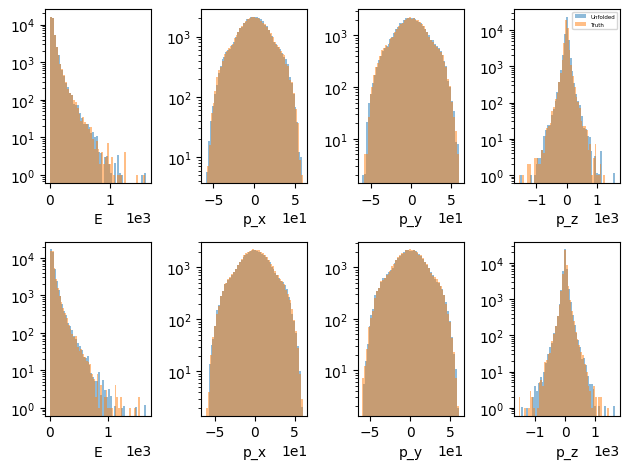

In [ ]:
import matplotlib.pyplot as plt

labels = ["E", "p_x", "p_y", "p_z"]
plt.subplot(2, 4, 1)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.hist(y_detector_sim_val[:, i], bins=50, weights=output[0].reshape(-1, 1), alpha=0.5, label="Unfolded")
    plt.hist(y_detector_sim_test[:, i], bins=50, alpha=0.5, label="Truth")
    if i == 3:
        plt.legend(prop={'size': 4})
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.yscale('log')
    plt.xlabel(labels[i % 4])
plt.tight_layout()